In [1]:
import numpy as np
import os
import jax
import jax.numpy as jnp
import trimesh
import time
import jax3dp3.transforms_3d as t3d
import jax3dp3 as j
from dataclasses import dataclass
import sys

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")

intrinsics = j.Intrinsics(
    height=150,
    width=150,
    fx=200.0, fy=200.0,
    cx=75.0, cy=75.0,
    near=0.001, far=5.0
)

renderer = j.Renderer(intrinsics)
model_names = j.ycb_loader.MODEL_NAMES
for IDX in range(len(model_names)):
    mesh_path_ply = os.path.join(model_dir,"obj_" + "{}".format(IDX+1).rjust(6, '0') + ".ply")
    mesh = j.mesh.load_mesh(mesh_path_ply)
    renderer.add_mesh(mesh, scaling_factor=1.0/1000.0)

Increasing frame buffer size to (width, height, depth) = (160, 160, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [6]:
table_dims = jnp.array([1.0, 1.0, 0.005])
table_mesh = j.mesh.make_cuboid_mesh(table_dims)
renderer.add_mesh(table_mesh)

In [7]:
renderer.model_box_dims.shape

(23, 3)

In [8]:
object_indices = jnp.array([21, 0, 1])
box_dims = renderer.model_box_dims[object_indices]

In [73]:
absolute_poses = jnp.array([
    j.t3d.inverse_pose(cam_pose),
    jnp.eye(4),
    jnp.eye(4),
])


edges = jnp.array([
    [-1,0],
    [0,1],
    [0,2],
])


contact_params = jnp.array(
    [
        [0.0, 0.0, 0.0],
        [0.2, 0.0, 0.0],
        [-0.1, 0.0, 0.0]
    ]
)

face_parents = jnp.array([2,2,2])
face_child = jnp.array([0,0,0])
gt_poses = j.scene_graph.absolute_poses_from_scene_graph_jit(
    absolute_poses, box_dims, edges, contact_params, face_parents, face_child
)

In [74]:
cam_pose = j.t3d.transform_from_pos_target_up(
    jnp.array([0.6, 0.6, 0.6]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)

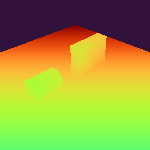

In [75]:
observed_img = renderer.render_multiobject(gt_poses, object_indices)
j.get_depth_image(observed_img[:,:,2])

In [76]:
absolute_poses_from_scene_graph_parallel_jit = jax.jit(jax.vmap(
    j.scene_graph.absolute_poses_from_scene_graph, in_axes=(None, None, None, 0, None, None)
))

In [107]:
reconstruction.shape

(150, 150, 4)

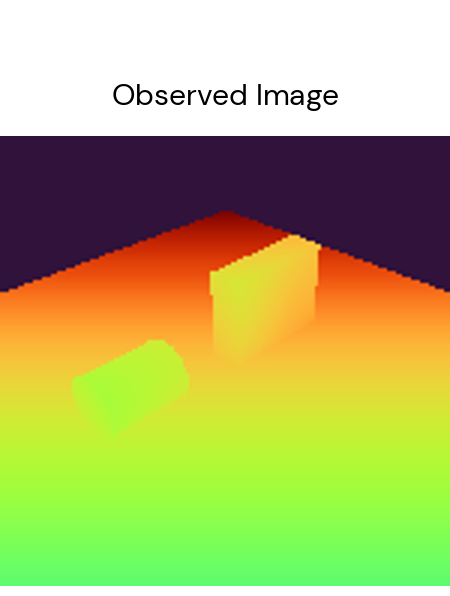

In [138]:
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
    ],
    middle_width=30
)

In [139]:
R = 0.001
OUTLIER_PROB = 0.1
OUTLIER_VOLUME = 100.0

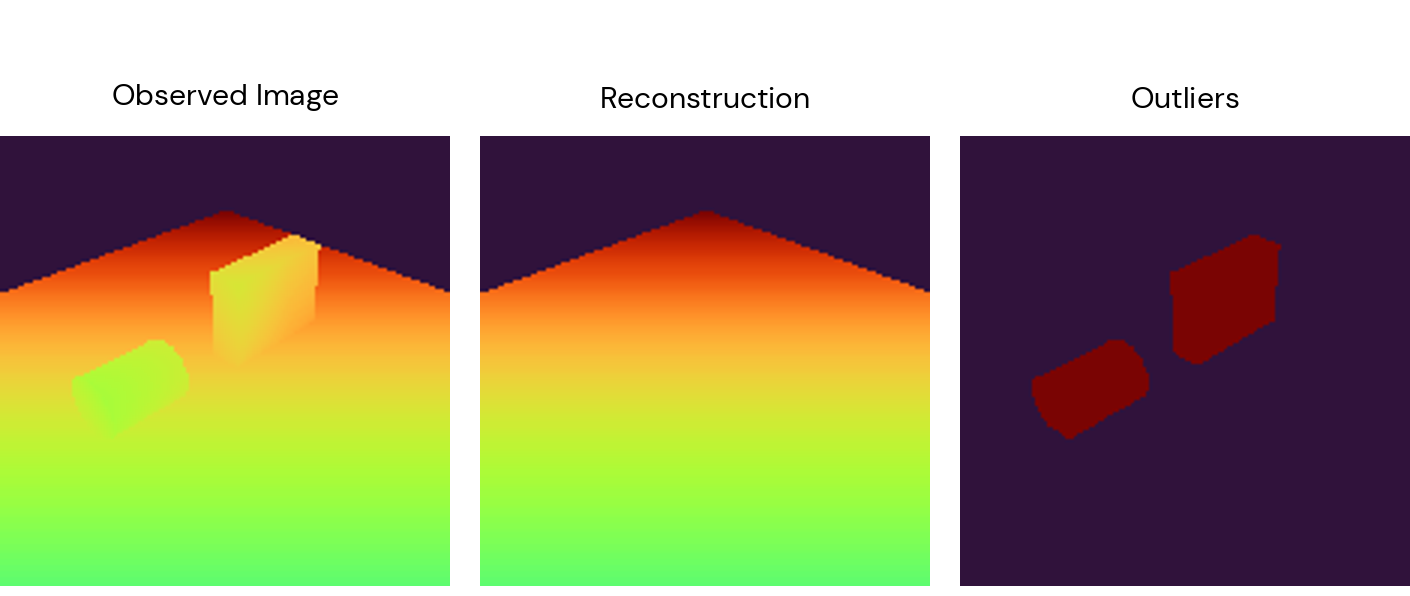

In [145]:
object_idx = 0 
reconstruction = renderer.render_multiobject(
    gt_poses, object_indices[:object_idx+1]
)
outliers = (
    (j.gaussian_mixture_image(observed_img, reconstruction, R) * (1.0 - OUTLIER_PROB)) 
        <
    (OUTLIER_PROB / OUTLIER_VOLUME)
)
SCALING_FACTOR = 3.0
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Outliers",
    ],
    middle_width=30
)

In [146]:
contact_params = jnp.array(
    [
        [0.0, 0.0, 0.0],
    ]
)
contact_param_grid = j.make_translation_grid_enumeration_3d(
    -0.4, -0.4, 0.0,
    0.4, 0.4, 0.0,
    100,100,1
)

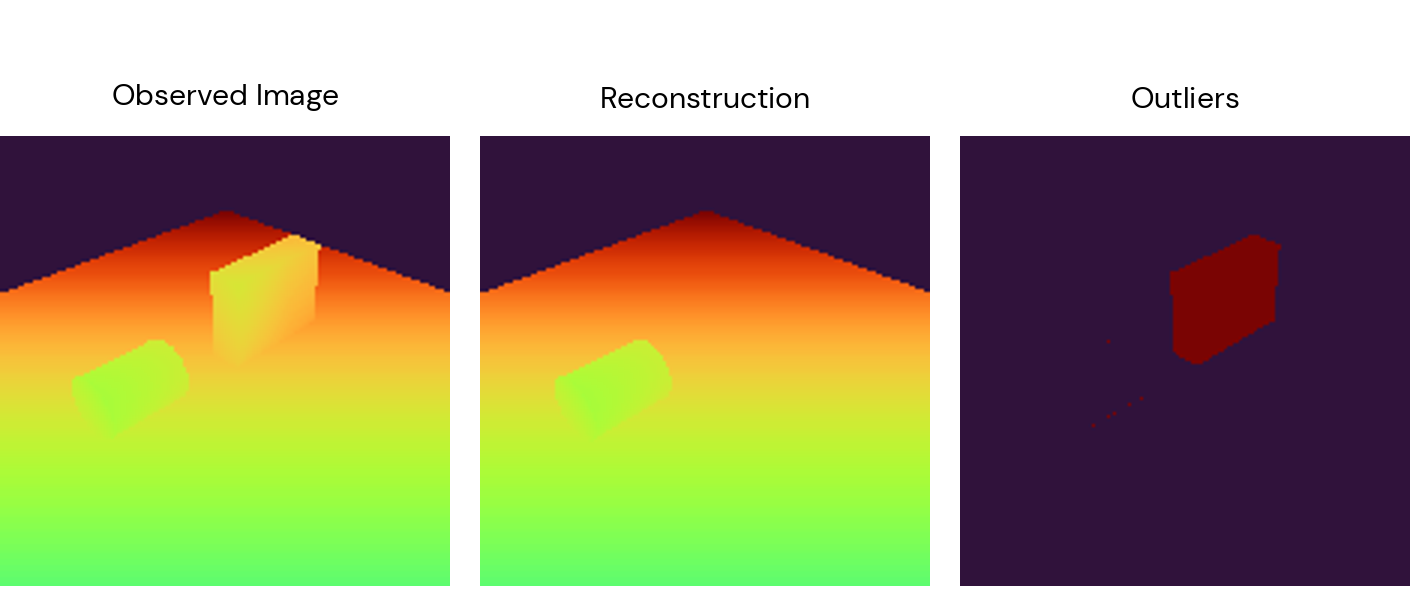

In [147]:
object_idx = 1

contact_params_tiled = jnp.tile(contact_params[None,...], (contact_param_grid.shape[0],1,1))
contact_params_tiled = jnp.concatenate([contact_params_tiled, contact_param_grid[:,None,...]],axis=1)
poses = absolute_poses_from_scene_graph_parallel_jit(
    absolute_poses[:object_idx+1], box_dims[:object_idx+1], edges[:object_idx+1], contact_params_tiled,
    face_parents[:object_idx+1], face_child[:object_idx+1]
)
rendered_images = renderer.render_multiobject_parallel(jnp.transpose(poses,axes=(1,0,2,3)), object_indices[:object_idx+1])
weights = j.threedp3_likelihood_parallel_jit(observed_img, rendered_images, R, OUTLIER_PROB, OUTLIER_VOLUME)
contact_params = contact_params_tiled[weights.argmax(),:object_idx+1,:]
reconstruction = rendered_images[weights.argmax()]
outliers = (
    (j.gaussian_mixture_image(observed_img, reconstruction, R) * (1.0 - OUTLIER_PROB)) 
        <
    (OUTLIER_PROB / OUTLIER_VOLUME)
)
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Outliers",
    ],
    middle_width=30
)

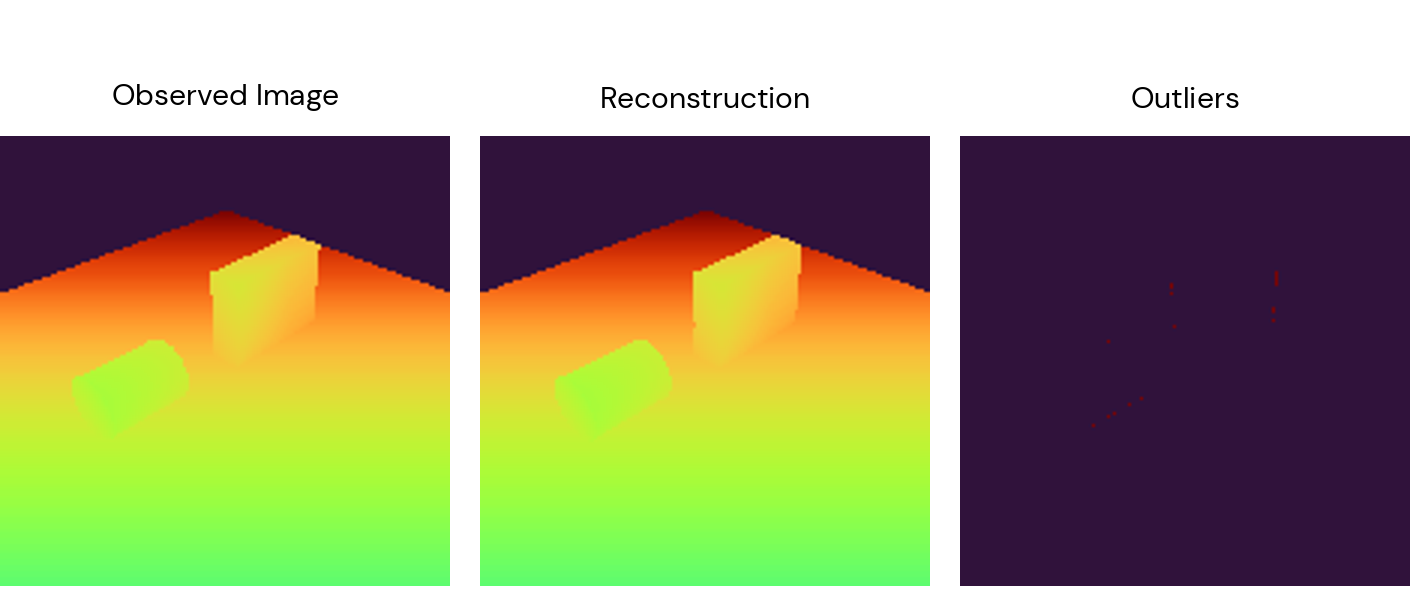

In [148]:
object_idx = 2

contact_params_tiled = jnp.tile(contact_params[None,...], (contact_param_grid.shape[0],1,1))
contact_params_tiled = jnp.concatenate([contact_params_tiled, contact_param_grid[:,None,...]],axis=1)
poses = absolute_poses_from_scene_graph_parallel_jit(
    absolute_poses[:object_idx+1], box_dims[:object_idx+1], edges[:object_idx+1], contact_params_tiled,
    face_parents[:object_idx+1], face_child[:object_idx+1]
)
rendered_images = renderer.render_multiobject_parallel(jnp.transpose(poses,axes=(1,0,2,3)), object_indices[:object_idx+1])
weights = j.threedp3_likelihood_parallel_jit(observed_img, rendered_images, R, OUTLIER_PROB, OUTLIER_VOLUME)
contact_params = contact_params_tiled[weights.argmax(),:object_idx+1,:]
reconstruction = rendered_images[weights.argmax()]
outliers = (
    (j.gaussian_mixture_image(observed_img, reconstruction, R) * (1.0 - OUTLIER_PROB)) 
        <
    (OUTLIER_PROB / OUTLIER_VOLUME)
)
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Outliers",
    ],
    middle_width=30
)